In [1]:
import pandas as pd

csv_path = "/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/250331_sum_aligned_good_path.csv"
df = pd.read_csv(csv_path)
session_paths = df['path'].tolist()


Plotting session (with exclusion) from: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37


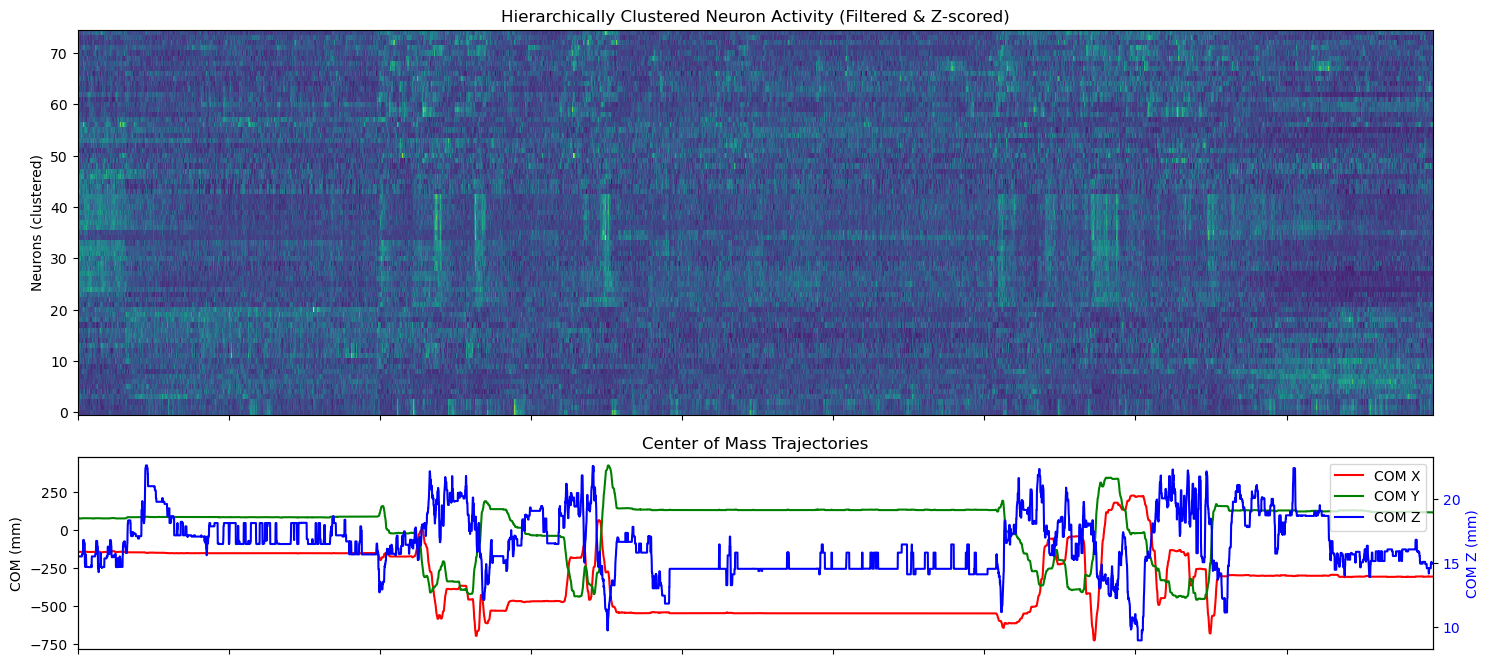

Plotting session (with exclusion) from: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53


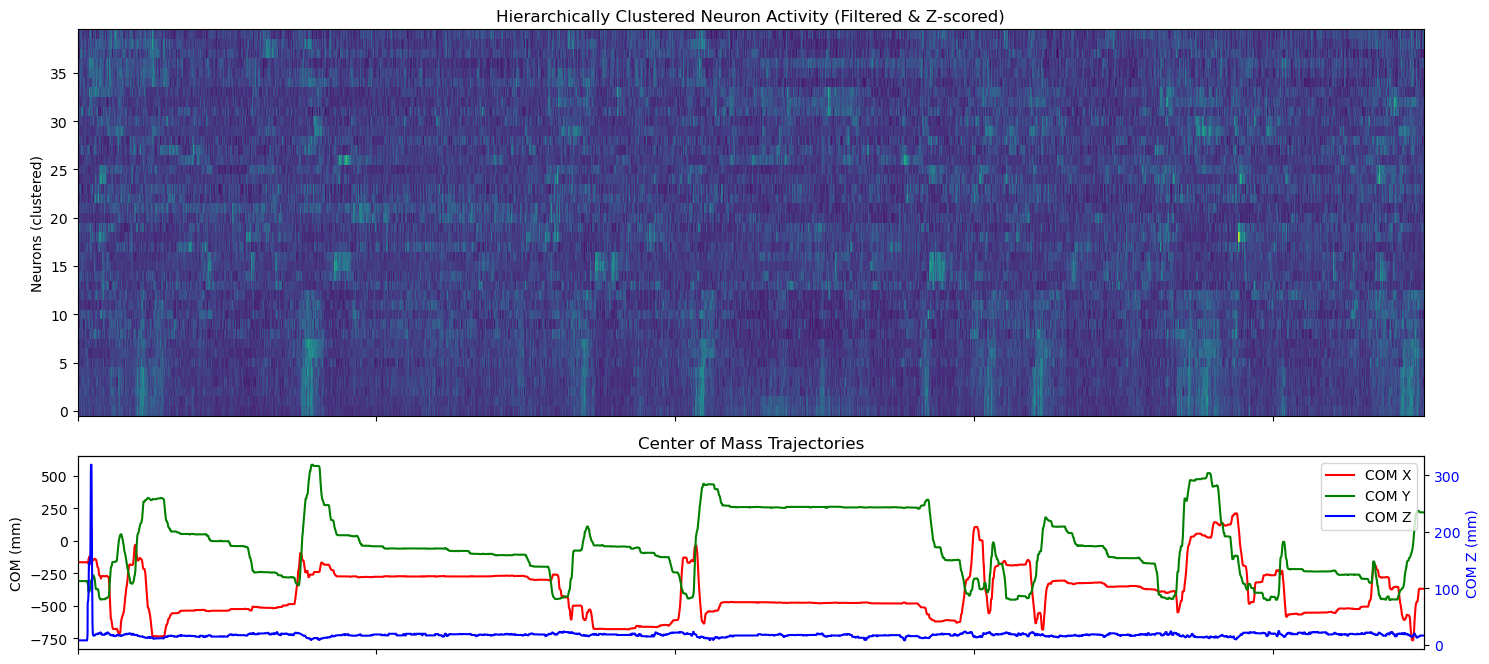

Plotting session (with exclusion) from: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30


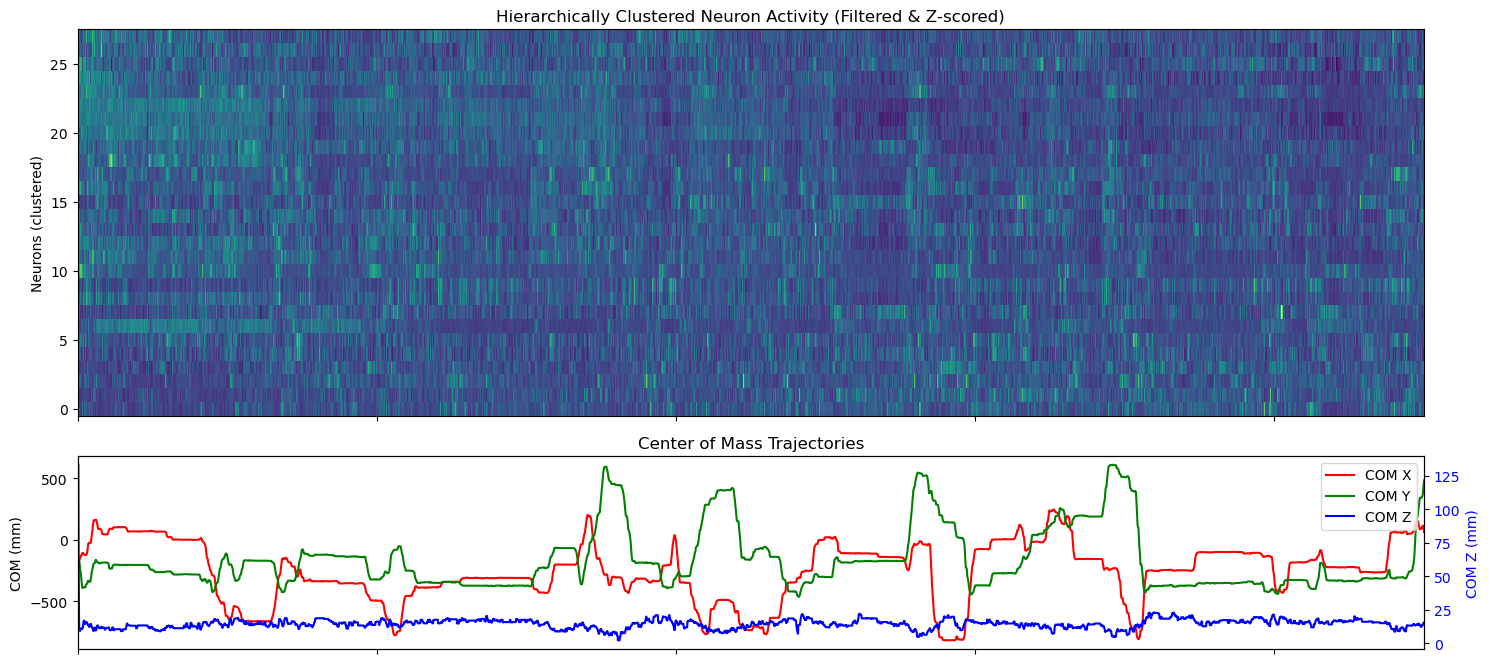

Plotting session (with exclusion) from: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58


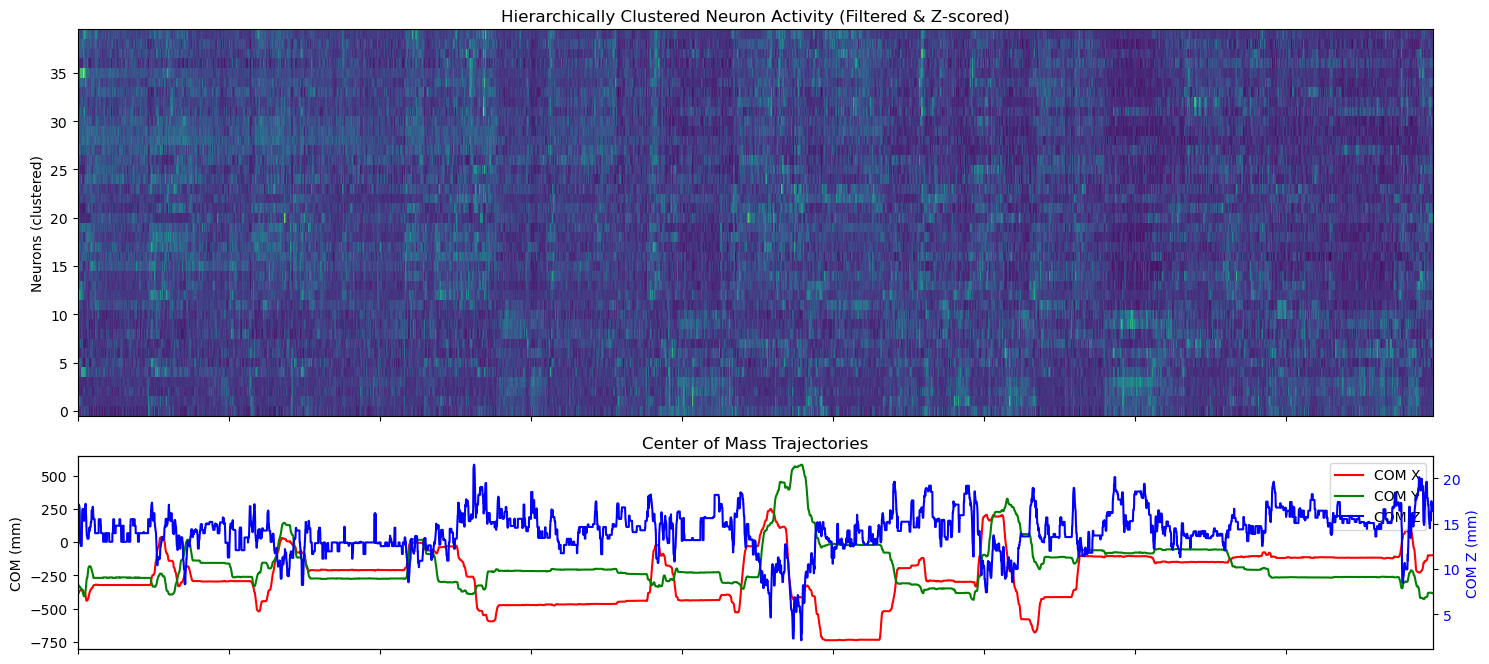

Plotting session (with exclusion) from: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41


FileNotFoundError: File /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5 does not exist

In [3]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore

# ------------------------------------------------------------------------------
# 1. Load the JSON file with excluded neurons mapping
# ------------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    Given a session path and the exclusion dictionary loaded from JSON,
    return the list of excluded neuron indices.
    If an exact match is not found, try to match by substring.
    """
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []  # Default to no exclusions if not found

# ------------------------------------------------------------------------------
# 2. Data Loading with Metadata
# ------------------------------------------------------------------------------
def load_session_data(rec_path):
    """
    Load a single session's HDF5 file, parse the folder structure to extract metadata,
    and return the resulting DataFrame with added metadata columns.
    
    Example of the folder structure:
      /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_15_42

    Where:
      - session_id   = 20241002PMCr2_15_42  (last directory)
      - recording_date = 2024_10_25        (parent directory)
      - experiment   = Oct3V1              (grandparent directory)
    """
    hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned', 'aligned_predictions_with_ca_and_dF_F.h5')
    df = pd.read_hdf(hdf5_file_path, key='df')
    
    norm_path = os.path.normpath(rec_path)
    session_id = os.path.basename(norm_path)
    recording_date = os.path.basename(os.path.dirname(norm_path))
    experiment_name = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    
    df['session_id'] = session_id
    df['recording_date'] = recording_date
    df['experiment'] = experiment_name
    df['session_path'] = rec_path
    df['file_path'] = hdf5_file_path
    
    return df

# ------------------------------------------------------------------------------
# 3. Processing Neuron Activity Data with Optional Exclusion
# ------------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    """
    Process neuron activity data:
      - Optionally exclude specific neurons.
      - Remove low-variance neurons.
      - Z-score normalize each neuron's time course.
    
    Parameters:
      - df: DataFrame with neuron activity and metadata.
      - exclude_dict: Dictionary from the JSON mapping (optional).
      - manual_exclude_indices: List of neuron indices to exclude manually (optional).
      - apply_exclusion: If False, skip neuron exclusion.
    
    Returns:
      - neuron_activity_normalized: np.array of shape (neurons, timepoints)
      - filtered_neuron_columns: list of neuron column names after filtering
      - df_new: reset-index DataFrame used for plotting (should contain timestamp info)
    """
    # Determine which neurons to exclude
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded_indices = manual_exclude_indices
        elif exclude_dict is not None:
            session_path = df['session_path'].iloc[0]
            excluded_indices = get_excluded_neurons_for_session(session_path, exclude_dict)
        else:
            excluded_indices = []
    else:
        excluded_indices = []
    
    # Build the list of column names to exclude based on the neuron indices
    manual_excluded_neurons = [f'dF_F_roi{i}' for i in excluded_indices]
    
    # Select neuron columns that start with 'dF_F_roi' and are not in the excluded list.
    neuron_columns = [
        col for col in df.columns 
        if col.startswith('dF_F_roi') and col not in manual_excluded_neurons
    ]
    
    # Extract neuron activity data and transpose to shape (neurons, timepoints)
    neuron_activity = df[neuron_columns].values.T
    
    # Remove low-variance neurons (keep top 95% variance)
    neuron_variances = np.var(neuron_activity, axis=1)
    threshold = np.percentile(neuron_variances, 5)
    high_variance_indices = neuron_variances > threshold
    neuron_activity_filtered = neuron_activity[high_variance_indices, :]
    filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]
    
    # Z-score normalization along each neuron's time course
    neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)
    
    # Reset index for plotting convenience (assumes a 'timestamp_ms_mini' column exists)
    df_new = df.reset_index()
    
    return neuron_activity_normalized, filtered_neuron_columns, df_new

# ------------------------------------------------------------------------------
# 4. Plotting Function with Optional Exclusion
# ------------------------------------------------------------------------------
def plot_session_data(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    """
    Produce a figure with:
      - A heatmap of hierarchically clustered neuron activity.
      - Center of mass (COM) trajectories.
    
    Parameters:
      - df: DataFrame with session data.
      - exclude_dict: Dictionary for exclusion (optional).
      - manual_exclude_indices: List of neuron indices to exclude manually (optional).
      - apply_exclusion: If False, plot all neurons without exclusion.
    
    Expects the DataFrame to have a 'timestamp_ms_mini' column for the x-axis.
    """
    neuron_activity_normalized, filtered_neuron_columns, df_new = process_neuron_activity(
        df, exclude_dict=exclude_dict, manual_exclude_indices=manual_exclude_indices, apply_exclusion=apply_exclusion
    )
    time = df_new['timestamp_ms_mini']
    
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[2, 1, 1.5])
    
    # --- Plot 1: Ca²⁺ Heatmap of Clustered Neuron Activity ---
    ax1 = fig.add_subplot(gs[0, 0])
    if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
        # Hierarchical clustering using Ward linkage
        Z = linkage(neuron_activity_normalized, method='ward')
        neuron_order = leaves_list(Z)
        neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
        ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]
        
        neuron_indices = np.arange(len(neuron_activity_ordered))
        mesh = ax1.pcolormesh(
            time, neuron_indices, neuron_activity_ordered,
            cmap='viridis', shading='auto'
        )
        ax1.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
        ax1.set_ylabel('Neurons (clustered)')
    else:
        print("Neuron activity data not found. Skipping heatmap plot.")
        ax1.text(0.5, 0.5, 'No neuron activity data available.',
                 transform=ax1.transAxes, ha='center', va='center')
        ax1.set_title('No Neuron Activity Plot')
    ax1.tick_params(labelbottom=False)
    
    # --- Plot 2: Center of Mass (COM) Trajectories ---
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
        ax2.plot(time, df_new['com_x'], color='red', label='COM X')
        ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
        ax2.set_ylabel('COM (mm)')
        ax2.set_title('Center of Mass Trajectories')
        
        # Secondary y-axis for COM Z
        ax2_right = ax2.twinx()
        ax2_right.plot(time, df_new['com_z'], color='blue', label='COM Z')
        ax2_right.set_ylabel('COM Z (mm)', color='blue')
        ax2_right.tick_params(axis='y', labelcolor='blue')
        
        # Combine legends from both axes
        lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()
        lines_ax2_right, labels_ax2_right = ax2_right.get_legend_handles_labels()
        ax2.legend(lines_ax2 + lines_ax2_right, labels_ax2 + labels_ax2_right, loc='upper right')
    else:
        print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
    ax2.tick_params(labelbottom=False)
    
    # (Additional subplots can be added here)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 5. Example Usage
# ------------------------------------------------------------------------------
# Suppose you have several session folder paths.
# session_paths = [
#     '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_15_42', 
#     '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05',
# ]

# Process and plot each session individually

# Example 1: Plot with exclusion from the JSON (or manual if provided)
for path in session_paths:
    print(f"Plotting session (with exclusion) from: {path}")
    df_session = load_session_data(path)
    plot_session_data(df_session, exclude_dict=exclude_dict, apply_exclusion=True)
    
# Example 2: Plot all neurons (i.e. no exclusion)
for path in session_paths:
    print(f"Plotting session (all neurons) from: {path}")
    df_session = load_session_data(path)
    plot_session_data(df_session, apply_exclusion=False)

# ------------------------------------------------------------------------------
# Alternatively, you can load multiple sessions and then filter them later
def load_multiple_sessions(rec_paths):
    session_dfs = []
    for path in rec_paths:
        df_session = load_session_data(path)
        session_dfs.append(df_session)
    df_all = pd.concat(session_dfs, ignore_index=True)
    return df_all

# Example: load all sessions into one master DataFrame.
df_all_sessions = load_multiple_sessions(session_paths)
# Then later you might filter by metadata (e.g., session_id, recording_date) and plot.
